# KNN Classification-based Prediction of Heart Disease Diagnoses

## Introduction
Heart disease is a significant global health concern; it is the *leading cause of death globally*. To address this issue effectively, it is vital to develop accurate diagnostic tools. Fortunately, there are many patient attributes that could serve as indicators or possible warning signs for heart disease, which could accelerate the process of diagnosis and treatment. In this project, we will employ classification techniques to predict the diagnosis of heart disease based on a few of these attributes.

**Research question:** Will a patient be diagnosed with heart disease, given their age, resting blood pressure, cholesterol levels, and maximum heart rate achieved, while considering sex differences?

The dataset we will use to answer this question is the UCI Heart Disease dataset, which comprises multivariate numerical and categorical data on 14 patient attributes. These include age, sex, chest pain type, etc. along with the patient's diagnosis. For this project, we will focus on a subset of attributes: 
- age
- resting blood pressure
- serum cholesterol
- maximum heart rate achieved

to predict the diagnosis of heart disease. We will filter the dataset to include only records from the Cleveland location to ensure consistency and relevance. By the end of this project, we aim to develop accurate predictive models for diagnosing heart disease based on patient attributes.

## Exploratory data analysis

In [1]:
# Run this cell before continuing
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 5)
set.seed(69)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
heart <- read_csv("https://raw.githubusercontent.com/chiefpat450119/dsci-project/main/data/heart_disease_uci.csv")

Rows: 920 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): sex, dataset, cp, restecg, slope, thal
dbl (8): id, age, trestbps, chol, thalch, oldpeak, ca, num
lgl (2): fbs, exang

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We then filter the data to look at **only one location (Cleveland)** to reduce the effect of possible confounding variables introduced by the local environment.

In [3]:
cleveland_heart <- heart |>
filter(dataset == "Cleveland")

In order to use classification, we need to change the predicted variable (num) to a *factor* with more understandable levels. From the information presented in the dataset, num = 0 represents absence of disease, while num = 1, 2, 3, 4 represent stages of heart disease. The refactoring will be done based on the following interpretation:
- 0 = "absent"
- 1 = "mild"
- 2 = "moderate"
- 3 = "severe"
- 4 = "critical"

In [4]:
heart_refactored <- cleveland_heart |>
mutate(disease = as_factor(num)) |>
mutate(disease = fct_recode(disease, "absent" = "0", "mild" = "1", "moderate" = "2", "severe" = "3", "critical" = "4"))
heart_refactored

id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,disease
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<lgl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<fct>
1,63,Male,Cleveland,typical angina,145,233,TRUE,lv hypertrophy,150,FALSE,2.3,downsloping,0,fixed defect,0,absent
2,67,Male,Cleveland,asymptomatic,160,286,FALSE,lv hypertrophy,108,TRUE,1.5,flat,3,normal,2,moderate
3,67,Male,Cleveland,asymptomatic,120,229,FALSE,lv hypertrophy,129,TRUE,2.6,flat,2,reversable defect,1,mild
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
303,38,Male,Cleveland,non-anginal,138,175,FALSE,normal,173,FALSE,0,upsloping,NA,normal,0,absent
304,28,Male,Cleveland,atypical angina,130,132,FALSE,lv hypertrophy,185,FALSE,0,NA,NA,NA,0,absent


The data is already in a tidy format. We now split the data into a training and a testing set, making sure there are equal ratios of each disease classification in both sets. Let's take a look at how many cases are in each disease class, and then break it down by sex.

In [5]:
heart_split <- initial_split(heart_refactored, prop = 0.75, strata = disease)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

In [6]:
heart_train_summary <- heart_train |>
group_by(disease) |>
summarize(count = n())
heart_train_summary

disease,count
<fct>,<int>
absent,123
mild,40
moderate,25
severe,27
critical,11


In [7]:
options(repr.matrix.max.rows = 10)
heart_train_split <- heart_train |>
group_by(disease, sex) |>
summarize(count = n())
heart_train_split

`summarise()` has grouped output by 'disease'. You can override using the
`.groups` argument.


disease,sex,count
<fct>,<chr>,<int>
absent,Female,53
absent,Male,70
mild,Female,5
mild,Male,35
moderate,Female,4
moderate,Male,21
severe,Female,5
severe,Male,22
critical,Female,1


There is a difference in the distribution of cases between male and female patients. There is a **significantly greater proportion** of patients in the disease classes for male patients. This will need to be kept in mind for our analysis. 

Some disease classes have **very few observations,** especially for female patients. This will make it hard to train a useful classification model. Thus, let's **combine all the disease classes into one**:

In [8]:
options(repr.matrix.max.rows = 5)
heart_train <- mutate(heart_train, disease = case_when(disease == "absent" ~ "absent", TRUE ~ "present"))
heart_test <- mutate(heart_test, disease = case_when(disease == "absent" ~ "absent", TRUE ~ "present"))
heart_train

id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,disease
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<lgl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>
1,63,Male,Cleveland,typical angina,145,233,TRUE,lv hypertrophy,150,FALSE,2.3,downsloping,0,fixed defect,0,absent
4,37,Male,Cleveland,non-anginal,130,250,FALSE,normal,187,FALSE,3.5,downsloping,0,normal,0,absent
8,57,Female,Cleveland,asymptomatic,120,354,FALSE,normal,163,TRUE,0.6,upsloping,0,normal,0,absent
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
297,59,Male,Cleveland,asymptomatic,164,176,TRUE,lv hypertrophy,90,FALSE,1.0,flat,2,fixed defect,3,present
301,57,Male,Cleveland,asymptomatic,130,131,FALSE,normal,115,TRUE,1.2,flat,1,reversable defect,3,present


Let's see how many missing values there are for each predictor.

In [9]:
missing <- enframe(colSums(is.na(heart_train))) |>
pivot_wider(names_from = "name", values_from = "value")
missing

id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,0,0,0,0,0,1,5,1,0,0


### Selected predictors
- Age
- Resting blood pressure (trestbps)
- Serum cholesterol (chol)
- Maximum heart rate achieved (thalch)

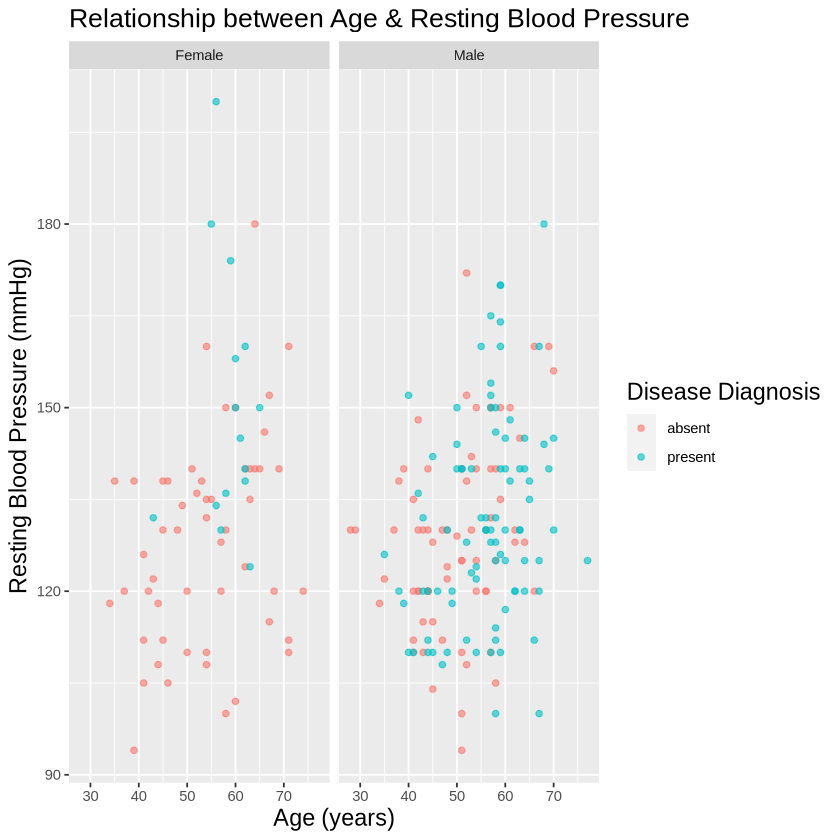

In [10]:
# Let's look at how two of predictor variables correlate with heart disease.
heart_age_bp_plot <- heart_train |>
  ggplot(aes(x = age, y = trestbps, color = disease)) +
  geom_point(alpha = 0.6) + 
  labs(x = "Age (years)", y = "Resting Blood Pressure (mmHg)", color = "Disease Diagnosis") +
  ggtitle("Relationship between Age & Resting Blood Pressure") +
  theme(
    plot.title = element_text(size = 16),  # Adjust title size
    axis.title = element_text(size = 14),  # Adjust axis label size
    legend.title = element_text(size = 14) # Adjust legend title size
  ) +
  facet_grid(cols = (vars(sex)))
heart_age_bp_plot

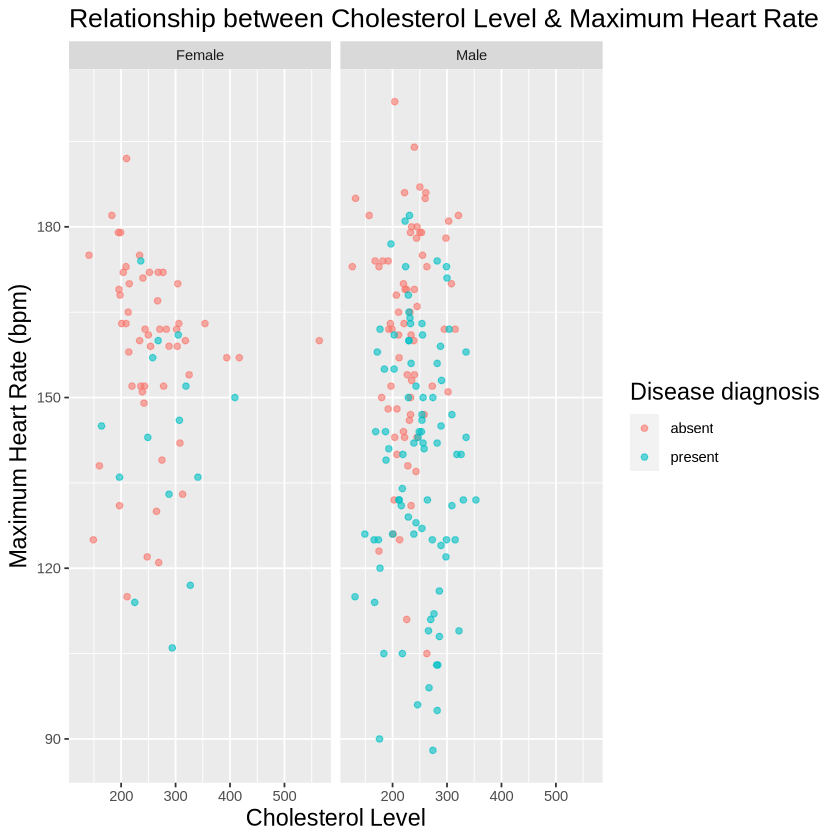

In [11]:
# Now the other two predictor variables
heart_chol_hr_plot <- ggplot(heart_train, aes(x = chol, y = thalch, color = disease)) + 
  geom_point(alpha = 0.6) + 
  labs(x = "Cholesterol Level", 
       y = "Maximum Heart Rate (bpm)", 
       color = "Disease diagnosis") + 
  ggtitle("Relationship between Cholesterol Level & Maximum Heart Rate") +
  theme(
    plot.title = element_text(size = 16),  # Adjust title size
    axis.title = element_text(size = 14),  # Adjust axis label size
    legend.title = element_text(size = 14) # Adjust legend title size
  ) +
  facet_grid(cols = (vars(sex)))
heart_chol_hr_plot

# Methods
To build a model for predicting the diagnosis of heart disease, we will follow the outlined approach.

In the data preprocessing phase, we will focus on filtering the dataset to include only observations from the Cleveland area, aiming to reduce potential confounding variables introduced by regional differences. Then, we will select the following predictors: age, resting blood pressure, cholesterol, and maximum heart rate.  
These were chosen because they are numerical variables, which are much more useful than the other categorical variables for KNN classification, and they also do not have any missing data. The disease classes will be combined into one because some of the original classes had too few observations to use classification effectively.

For model fitting and evaluation, we will split the dataset into training and testing sets, separately for male and female, due to the notable sex differences in diagnoses and predictor variables (see graphs above). We will be training a K-nearest neighbours classification model. The model will be trained on the training set, using cross-validation to choose the optimal value of K, then evaluated on the testing set using accuracy, precision, and recall. Recall will be prioritized because false negative predictions (classifying disease "present" as "absent") are more costly. This evaluation process will be conducted separately for male and female categories to account for sex-specific variations.

We will visualize our findings by creating four scatter plots with the **training data**, each representing a unique combination of variables. For each sex, we will plot blood pressure against age and maximum heart rate against cholesterol, colouring points by the patient's predicted diagnosis. The plot background will be coloured according to the predicted class at each point. This can be done for several values of K during the cross-validation to assess under- or over-fitting. These scatter plots will serve to identify any discernible patterns or correlations between the selected variables and heart disease diagnosis, facilitating the interpretation of our predictive models.  
We will also visualize the accuracy, precision, and recall when the model is evaluated on the **test data** using bar charts, along with bar charts visualizing the confusion matrix (true positives, false positives, etc.) for each sex.

## Expected outcomes and significance
Based on the outlined methods, we expect to find predictive models capable of accurately diagnosing heart disease based on patient attributes like age, blood pressure, cholesterol, and maximum heart rate achieved. Such findings could lead to improved early detection and treatment, potentially reducing the burden of heart disease globally. Future questions may explore the effectiveness of these models across different demographics, as well as their integration into clinical practice for better patient outcomes.